In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
import nbimporter
import random_forest_method

/Users/mortenolsenosvik/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mortenolsenosvik/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mortenolsenosvik/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mortenolsenosvik/anaconda3/lib/python3.7/s

Importing Jupyter notebook from random_forest_method.ipynb


### Technique of loading data and training model simultaniously (NOT IN USE)

In [2]:
#counter = 0
#for chunk in pd.read_csv(path, chunksize=1000000): #, compression='zip'):
#    counter +=1
    # Do model training here:
#    print('Reading batch {} / 52'.format(counter), end='\r')
#print('\nReading Complete!')

### Map status code to status description

In [3]:
fault_dict = {}
fault_dict['Other'] = 'Other'
fault_dict['Status_9_Substatus_8'] = 'Generator heating - (Manual)'
fault_dict['Status_62_Substatus_7'] = 'Feeding fault - (Diff. P-set/P-actual)'
fault_dict['Status_62_Substatus_30'] = 'Feeding fault - (Feeding safety circuit faulty)'
def get_description_from_status(status):
    return fault_dict[status]
    

### Method to print amount and percentage of statuses in datset

In [4]:
def get_statues_percentage(dataframe, description):
    status_count = dataframe.Status.value_counts()
    total_status_count = dataframe.shape[0]
    print('Proportion of failures in {}'.format(description))
    print('Status\t\t\t Percentage\t Amount')
    print('Other:\t\t\t {0:.3f}%\t {1}'.format(100*status_count[0]/(total_status_count), status_count[0]))
    print('Status_9_Substatus_8: \t {0:.3f} %\t {1}'.format(100*status_count[1]/(total_status_count), status_count[1]))
    print('Status_62_Substatus_7:\t {0:.3f}%\t\t {1}'.format(100*status_count[2]/(total_status_count), status_count[2]))
    print('Status_62_Substatus_30:\t {0:.3f}%\t\t {1}'.format(100*status_count[3]/(total_status_count), status_count[3]))
    print('')

### Create bar plot of amount of statuses

In [5]:
def plot_balance(dataframe, column):
    s = dataframe[column].value_counts()
    fig, ax = plt.subplots()

    # Remove the plot frame lines. They are unnecessary chartjunk.  
    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  

    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()  

    # Make sure your axis ticks are large enough to be easily read.  
    # You don't want your viewers squinting to read your plot.  
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)  

    plt.ylabel("Frequency of fault", fontsize=14)  
    plt.xlabel("Fault type", fontsize=14)  
    
    
    dataframe[column].value_counts().plot(ax=ax, kind='bar')
    plt.figure(figsize=(20, 16))

    #Save file
    plt.savefig('../Data_Plots/data_balance')
    

### Loading dataset without missing values

In [6]:
path = "../../../../../../XAI_Datasets/Data/all_data_filled.csv"
#'/Users⁩/mortenolsenosvik⁩/⁨XAI_Datasets⁩/Data/'
data = pd.read_csv(path) #, nrows=500000)

### Undersampling the dataset 

In [7]:
def undersample_dataset(dataset, sample_amount):
    # Extract each status
    others = dataset.loc[dataset['Status'] == 'Other']
    status_9_Substatus_8   = dataset.loc[dataset['Status'] == 'Status_9_Substatus_8']
    status_62_Substatus_7  = dataset.loc[dataset['Status'] == 'Status_62_Substatus_7']
    status_62_Substatus_30 = dataset.loc[dataset['Status'] == 'Status_62_Substatus_30']

    # undersampe the majority class ('Other')
    sampled_others = others.sample(sample_amount, random_state = 12)
    undersampled_data = pd.concat([sampled_others, status_9_Substatus_8, 
                                   status_62_Substatus_7, status_62_Substatus_30], ignore_index=True)
    undersampled_data = shuffle(undersampled_data)
    undersampled_data.reset_index(inplace=True, drop=True)

    # Save dataframe to csv
    undersampled_data.to_csv('../../../../../../XAI_Datasets/Data/undersampled_data.csv', 
                             encoding='utf-8', index=False)
    
    return(undersampled_data)


In [8]:
undersampled_data = undersample_dataset(data, 300000)
#get_statues_percentage(data, 'the unprocessed dataset')
#get_statues_percentage(undersampled_data, 'the undersampled dataset')


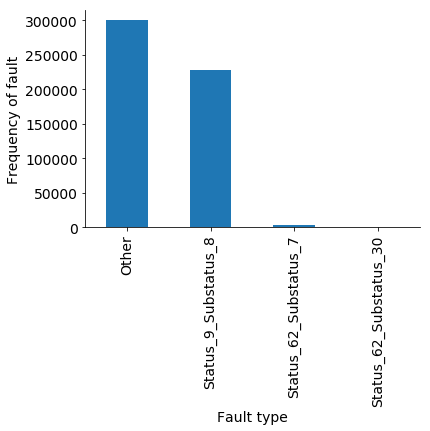

<Figure size 1440x1152 with 0 Axes>

In [9]:
plot_balance(undersampled_data, 'Status')

In [36]:
X = undersampled_data.drop(columns = ['Status', 'TimeStamp'])
y = undersampled_data.Status

In [37]:
X_train, X_test, y_train, y_test = random_forest_method.split_data(X,y)

In [38]:
rf, y_train_pred, y_test_pred = random_forest_method.train_rf_model(X_train,y_train, X_test)

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    classes = unique_labels(y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax


In [40]:
y_test.value_counts()

Other                     98928
Status_9_Substatus_8      75559
Status_62_Substatus_7      1340
Status_62_Substatus_30      113
Name: Status, dtype: int64

In [50]:
liksom = pd.DataFrame(y_test_pred)
liksom

,0
0,Status_9_Substatus_8
1,Other
2,Status_9_Substatus_8
3,Other
4,Other
5,Other
6,Status_9_Substatus_8
7,Other
8,Status_9_Substatus_8
9,Other


In [56]:
unique_labels(y_test_pred)

array(['Other', 'Status_62_Substatus_30', 'Status_62_Substatus_7',
       'Status_9_Substatus_8'], dtype='<U22')

In [52]:
target_class = y_test.unique()
print(target_class)

['Status_9_Substatus_8' 'Other' 'Status_62_Substatus_7'
 'Status_62_Substatus_30']


Normalized confusion matrix
[[9.97614427e-01 6.06501698e-05 7.48018761e-04 1.57690442e-03]
 [2.03539823e-01 7.87610619e-01 0.00000000e+00 8.84955752e-03]
 [4.47761194e-02 0.00000000e+00 9.55223881e-01 0.00000000e+00]
 [4.10275414e-04 0.00000000e+00 0.00000000e+00 9.99589725e-01]]


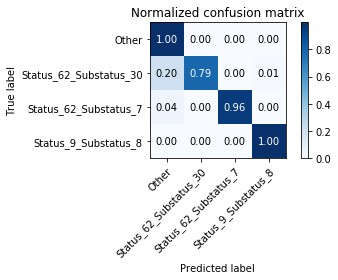

In [62]:
ax = plot_confusion_matrix(y_test,y_test_pred, normalize=True)

In [ ]:
def get_model(X,y,target_names):
    X_train, X_test, y_train, y_test = split_data(X,y)
    rf, y_train_pred, y_test_pred = train_rf_model(X_train,y_train, X_test)
    features_imp = get_feature_importances(rf,X_train)
    plot_confusion_matrix(y_test,y_test_pred, target_names, normalize=True)
    return features_imp
    

In [13]:
fet = random_forest_method.get_model(X, y, target_class)

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
fet

### SMOTE (Synthetic Minority Oversampling Technique):

In [ ]:
sm = SMOTE(random_state=12)
X_